In [1]:
import pvdeg

## Adding Points

We are going to add all of the points in the American West to the scenario and downsample by a factor of 1. This will include only half of the points in the latitude axis and half in the longitude axis.

In [23]:
dynamic_points = pvdeg.scenario.GeospatialScenario(
    name='dynamic-selection'
)

dynamic_points.addLocation(
    state=['CO', 'UT'],#, 'NM', 'NV', 'ID', 'WY', 'AZ', 'CA', 'OR', 'WA'],
    downsample_factor=1
)

/home/tford/.conda-envs/rpp/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "phony_dim_1" starting at index 500. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


### Preview The Scenario's Points

Use `plot_cords` to get a quick snapshot of all coordinates included in the scenario's metadata.

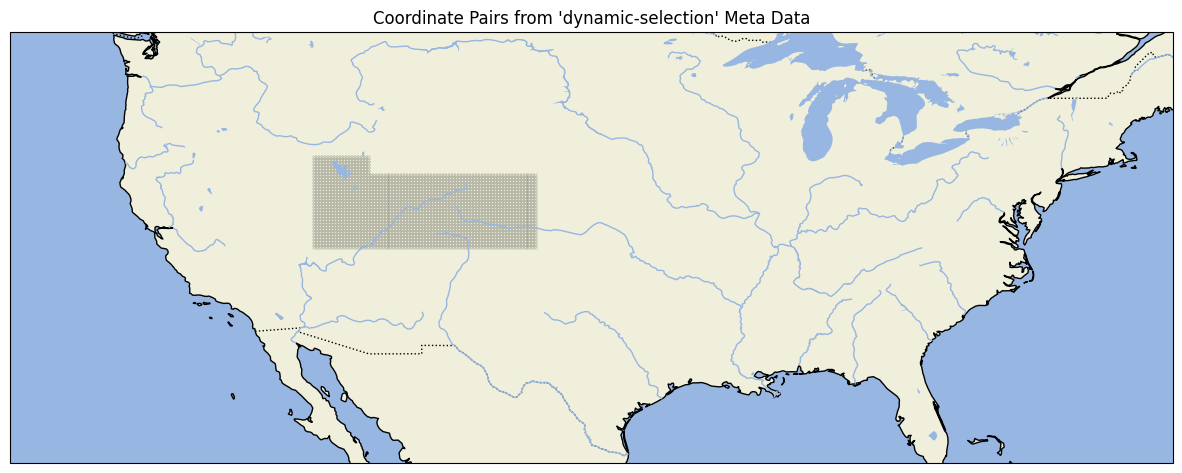

In [24]:
dynamic_points.plot_coords(
    coord_1 = [48.574790, -130.253906], # uncomment to see Larger scale view
    coord_2 = [25.482951, -68.027344],
    size = 0.005
)

## Downselecting

Using weighted random choices based on elevation we will create a sparse grid from the full metadata for fast calculations. This requires sklearn to be installed but this is not in the `pvdeg` dependency list to you will have to install it seperately.

In [32]:
dynamic_points.meta_data

,latitude,longitude,altitude,tz,country,state,county,wind_height
407393,38.529999,-108.260002,2203,-7,United States,Colorado,Montrose,2
295746,41.889999,-113.379997,2537,-7,United States,Utah,Box Elder,2
462552,37.410000,-105.860001,2297,-7,United States,Colorado,Alamosa,2
416313,37.889999,-107.860001,3061,-7,United States,Colorado,San Miguel,2
377412,37.250000,-109.620003,1352,-7,United States,Utah,San Juan,2
...,...,...,...,...,...,...,...,...
368545,38.209999,-110.019997,1527,-7,United States,Utah,Wayne,2
310605,41.810001,-112.660004,1496,-7,United States,Utah,Box Elder,2
343651,40.529999,-111.139999,2394,-7,United States,Utah,Wasatch,2
456842,38.849998,-106.099998,2682,-7,United States,Colorado,Chaffee,2


In [25]:
west_tree = pvdeg.geospatial.meta_KDtree(meta_df=dynamic_points.meta_data)

dynamic_points.downselect_elevation_stochastic(
    kdtree=west_tree,
    downselect_prop=0.1,
)

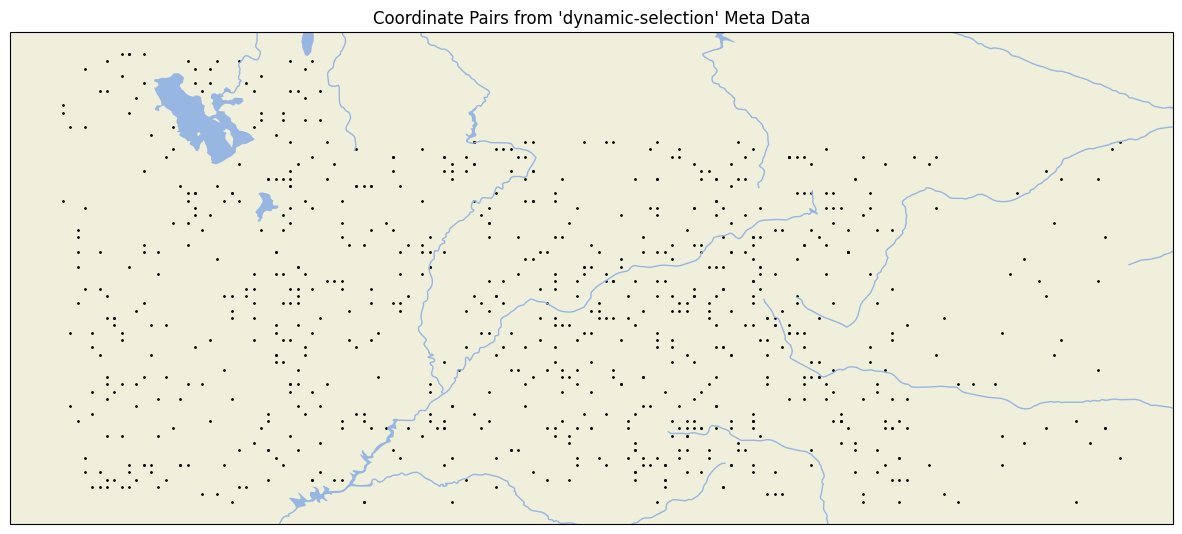

In [26]:
dynamic_points.plot_coords()

## Extracting from Scenario

Scenarios provide an easy way to select and downsample geospatial data but we can easily pull out the data to use other `pvdeg` functions on it. In the cell below, we extract the weather data and meta data from the scenario and take only the matching entries from the weather. Then we load the xarray dataset into memory. Previously, it was stored lazily out of memory but we want to do operations on it. (Chunking causes issues when calculating so this eliminates any chunks)

In [27]:
weather = dynamic_points.weather_data

sub_weather = weather.sel(gid=dynamic_points.meta_data.index) # downselect weather using restricted metadata set

sub_weather = sub_weather.compute() # load into memory

### Geospatial Calculation

Run a standoff calculation on the extracted scenario weather data and scenario meta data.

In [28]:
# geospatial analysis now

geo = {
    "func": pvdeg.standards.standoff,
    "weather_ds": sub_weather,
    "meta_df": dynamic_points.meta_data,
}

analysis_result = pvdeg.geospatial.analysis(**geo)

The array tilt angle was not provided, therefore the latitude tilt of 41.3 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provided, therefore the latitude tilt of 41.2 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provided, therefore the latitude tilt of 40.3 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provided, therefore the latitude tilt of 41.1 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provided, therefore the latitude tilt of 38.8 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provided, therefore the latitude tilt of 38.0 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provi

ValueError: conflicting sizes for dimension 'gid': length 795 on 'gid' and length 723 on {'gid': 'x'}

### Viewing Results

Inspecting the xarray dataset below shows us that we have many Not a Number (NaN) entries. These occur because we did not provide weather data at every point in the grid of possile latitude-longitude pairs. Expanding the `x` datavariable shows that there are some valid results but these are uncommon.

In [29]:
analysis_result

<xarray.Dataset> Size: 61kB
Dimensions:    (latitude: 42, longitude: 60)
Coordinates:
  * latitude   (latitude) float32 168B 37.01 37.09 37.17 ... 41.49 41.65 41.89
  * longitude  (longitude) float32 240B -113.9 -113.6 -113.4 ... -102.7 -102.6
Data variables:
    x          (latitude, longitude) float64 20kB nan nan nan ... nan nan nan
    T98_0      (latitude, longitude) float64 20kB nan nan nan ... nan nan nan
    T98_inf    (latitude, longitude) float64 20kB nan nan nan ... nan nan nan

## Plotting Sparse Data I

If we try to plot existing data with the current plotting methods exposed by `pvdeg` we will encounter issues. This will produce weak plotting results.

(<Figure size 640x480 with 2 Axes>,
 <GeoAxes: xlabel='longitude', ylabel='latitude'>)

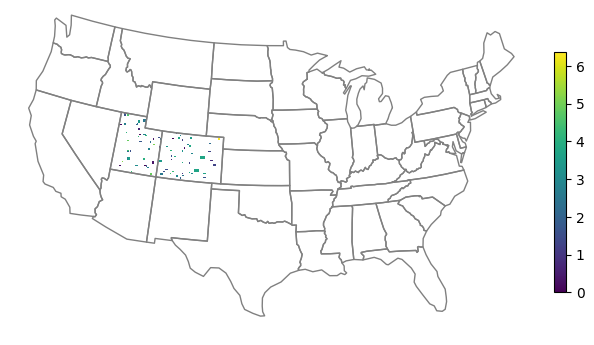

In [30]:
pvdeg.geospatial.plot_USA(analysis_result['x'])

## Plotting Sparse Data II

Utilize the new `plot_sparse_analysis` function below to interpolate and plot a solid color map. We can use different interpolation schemes but `nearest` and `linear` are best. See [scipy.interpolate.griddata](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html) for more information about interpolation.

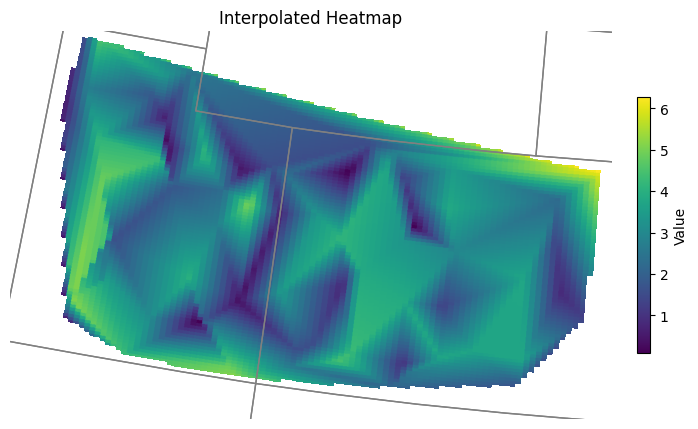

In [31]:
pvdeg.geospatial.plot_sparse_analysis(analysis_result, data_var='x', method='linear')